# Lecture 5 - Solutions

In [11]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

np.set_printoptions(precision=1)
np.random.seed(2)

## Binary logistic regression in higher dimensions 
In this exercise, we will again write a model for logistic regression with two label classes, but now with multiple input variables $x_1,x_2,\dots,x_n$. The goal of this exercise is to convince yourself that the material on binary logistic regression presented in the lecture notes still works in higher dimensions. You have to write the following:

$\textbf{Generation historical data}$:

1. Define a function that can generate vectors $x = (x_1,\dots,x_n)$ where $x_i$ is normally distributed with mean $\mu_i$ and standard deviation $\sigma_i = 1$. The inputs of this function are the number of vectors, the parameter $n$ and $\mu = (\mu_1,\dots,\mu_n)$. 
2.  Define a function that for given $n,m$ and means $\mu$ and $\nu$, generates $m$ vectors with mean $\mu$ (getting label $0$) and $m$ vectors with mean $\nu$ (getting label $1$). Make use of the function defined in part 1.

$\textbf{Data splitting:}$

3.  Write a function that divides the data into a training set of T% and test set of 100 - T%, where T is the input of the function.

$\textbf{Logistic regression:}$ 

4. Perform a logistic regression on the training set (with the T of your choice), and compare the label predictions for the test set with their true labels. Play around a bit with the regularization settings and with the different solvers available. Output the coefficients $(b_0,b_1,\dots,b_{n})$ of the sigmoid curve
$$
f(x) = \frac{1}{1 + e^{-p(x)}}
$$
with $p(x) = b_0 + \sum_i b_ix_i$.

5. Give a heatmap of the confusion matrix.
6. Give a scatter plot of the test data points with a point being blue if the label was correctly predicted as one, red if the label was correctly predicted as zero, and black if a point was incorrectly labelled.

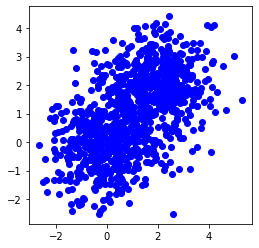

In [12]:
#1. Write the data generation function here
samples = 500
ndim = 2

#Generates vectors whose entries are standard normally distributed with given mean vector
def normal_data(npoints,ndim=3,mean=None):
    #The data points are given as columns.
    if mean is None:
        mean = np.zeros((ndim,1))
    vec = np.random.randn(ndim, npoints)
    return vec + mean

#2. 
def historic_data(samples,ndim,mean1,mean2):
    x = normal_data(samples,ndim,mean1)
    y = normal_data(samples,ndim,mean2)
    return np.hstack((x,y)), np.hstack((np.zeros(np.shape(x)[1]),np.ones(np.shape(y)[1])))

#We generate some data where mu is the zero-vector and nu the vector with twos everywhere.
#The 'labels' vector contains the corresponding label for every column data point in 'data'
data, labels = historic_data(samples,ndim,np.zeros((ndim,1)),2*np.ones((ndim,1)))

if ndim==2:
    fig = plt.figure(figsize=(4,4))
    plt.scatter(data[0,:],data[1,:],color='b')

In [13]:
#3. 
from sklearn.model_selection import train_test_split

def split(x,y,T):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=T, random_state=0)
    return x_train, x_test, y_train, y_test

data_train, data_test, label_train, label_test = split(data.T, labels, 0.3) #Note that we use data.T. Do you see why?

In [14]:
#4.
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C = 100, random_state=0, max_iter=200)
model.fit(data_train,label_train)

b0 = model.intercept_
print('Coefficient b_0 = {}'.format(b0))
b1 = model.coef_[0]
print('Coefficients b_1, b_2 = {}'.format(b1))

Coefficient b_0 = [-4.1]
Coefficients b_1, b_2 = [2. 2.]


[[139   5]
 [ 13 143]]


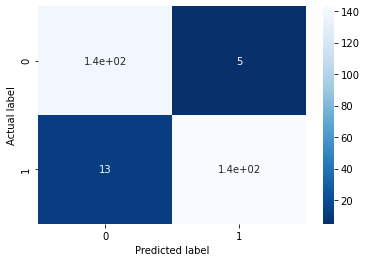

In [15]:
#5. 
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(label_test, model.predict(data_test))
print(cm)
sns.heatmap(cm,annot=True,cmap='Blues_r')
plt.xlabel('Predicted label')
plt.ylabel('Actual label');

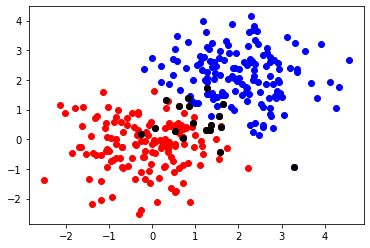

In [16]:
one_mask = np.where(model.predict(data_test) == 1)[0]
zero_mask = np.where(model.predict(data_test) == 0)[0]
fault_mask = np.where(model.predict(data_test) != label_test)

colors = ['blue','red','black']

for mask, c in zip([one_mask, zero_mask, fault_mask], colors):
    plt.scatter(data_test.T[0,mask],data_test.T[1,mask],color=c)

## The $k$-means algorithm: Do it yourself!
The goal of this exercise is to create your own implementation of the $k$-means algorithm. You should implement the following procedure for given data points $x_1,\dots,x_n$ and parameters $k,p \geq 1$:
1. Choose $k$ initial centers $c_1,\dots,c_k$. (You can do this randomly or come up with your own procedure.) 

For $t = 1,\dots,T$:

2. For every $x_i$, compute its closest center from $\{c_1,\dots,c_k\}$. The distance between two observations is measured using the $L_p$-norm, i.e., 
    
    $$
    ||y||_p = \left(\sum_i |y_i|^p\right)^{\frac{1}{p}}
    $$
For this you can use the `distance_matrix` function from `scipy.spatial`. Have a look at its documentation.
Let $G_j$ be all points assigned to cluster $c_j$.
3. For ever $j = 1,\dots,k$, compute the center of the points in $G_j$, i.e., 
$$
z_j = \frac{1}{|G_j|} \sum_{i \in G_j} x_i,
$$
and set $c_j \leftarrow z_j$.

<!--
4. <i>(Optional)</i> Keep track of the SSE of the clustering in every step $t$, and terminate the algorithm prematurely if the improvement in SSE is not significant. You may yourself what it means for an improvement to be 'significant' or not.
-->

In [30]:
import random
from scipy.spatial import distance_matrix
from sklearn.datasets import make_blobs

In [31]:
#1.
def init_center(x,k):
    #Data is given as row vectors
    return x[random.sample(range(np.shape(x)[0]),k),:]

In [57]:
#2.
def closest(x,centers,p):
    #This function returns for every row-vector in 'x' its closest center in the list 'centers'.
    #The distance is computed using the Minkowski p-norm
    return np.argmin(distance_matrix(x,centers,p=p), axis=1)

In [58]:
#3.
def new_clusters(x,old_clusters, closest_list):
    #Input: Data points x, list of centers old_clusters, 
    #and list closest_list containing closest center for every point in x
    #
    #Ouput: New list of clusters computed according to the z_j-formula given in the problem description. 
    k = np.max(closest_list)
    clusters = old_clusters
    for i in range(k+1):
        mask = np.where(closest_list == i)
        if np.size(mask) > 0:
            clusters[i,:] =  np.mean(x[mask],axis=0)
    return clusters

In [61]:
#k-means clustering
def clustering(x,k,p,T):
    #Repeatedly alternate between parts 2 and 3 of the algorithm for T steps.
    clusters = init_center(x,k)
    closest_list = closest(x,clusters,p)
    for i in range(T+1):
        clusters = new_clusters(x,clusters,closest_list)
        closest_list = closest(x,clusters,p)
    return clusters

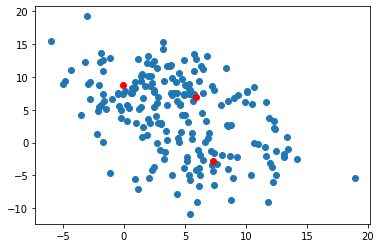

In [62]:
data, *_ = make_blobs(
     n_samples=200,
     centers=3,
     cluster_std=3.5,
     random_state=32
)

clusters = clustering(data,3,2,11)

plt.scatter(data[:,0],data[:,1])
plt.scatter(clusters[:,0],clusters[:,1],color='red');